In [42]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/image-stitching-opencv/images.zip" -d "/content/drive/My Drive/image-stitching-opencv"

In [0]:
# import the necessary packages
from imutils import paths
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [45]:
# grab the paths to the input images and initialize our images list
pathToImages = "/content/drive/My Drive/image-stitching-opencv/images"
print("Loading Images...")
imagePaths = sorted(list(paths.list_images(pathToImages)))
images = []

Loading Images...


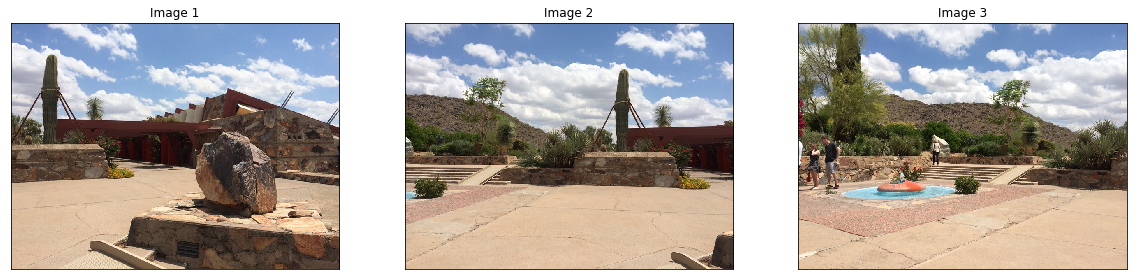

In [46]:
# loop over the image paths, load each one, and add them to our
# images to stich list
for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	images.append(image)
 
titles = ['Image 1', 'Image 2', 'Image 3']
plt.figure(figsize=(20,20))
plt.subplot(1,3,1),plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title(titles[0]), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
plt.title(titles[1]), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))
plt.title(titles[2]), plt.xticks([]), plt.yticks([])
plt.show()

In [47]:
# initialize OpenCV's image sticher object and then perform the image stitching
print("Stitching Images...")
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitchedImage) = stitcher.stitch(images)

Stitching Images...


Cropping...


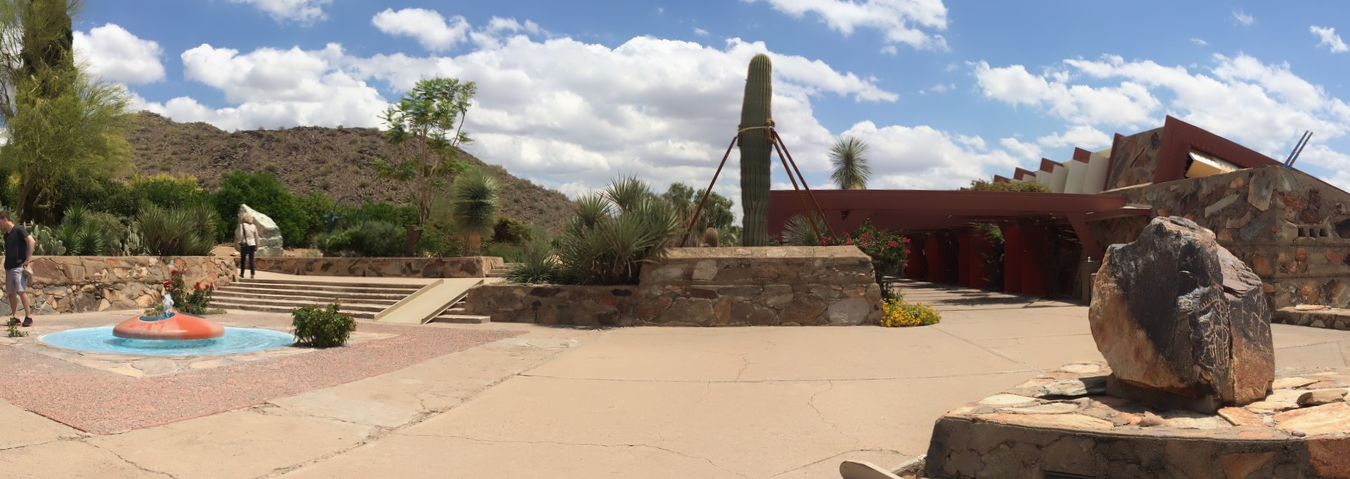

In [50]:
outputPath = "/content/drive/My Drive/image-stitching-opencv/output.png"
# if the status is '0', then OpenCV successfully performed image stitching
if status == 0:
	print("Cropping...")
 
	stitchedImage = cv2.copyMakeBorder(stitchedImage, 10, 10, 10, 10, cv2.BORDER_CONSTANT, (0, 0, 0))
	# Convert the stitched image to grayscale and threshold it
	# such that all pixels greater than zero are set to 255
	# (foreground) while all others remain 0 (background)
	gray = cv2.cvtColor(stitchedImage, cv2.COLOR_BGR2GRAY)
	thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

	# find all external contours in the threshold image then find
	# the *largest* contour which will be the contour/outline of
	# the stitched image
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# allocate memory for the mask which will contain the rectangular bounding box of the stitched image region
	mask = np.zeros(thresh.shape, dtype="uint8")
	(x, y, w, h) = cv2.boundingRect(c)
	cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

	# create two copies of the mask: one to serve as our actual
	# minimum rectangular region and another to serve as a counter
	# for how many pixels need to be removed to form the minimum
	# rectangular region
	minRect = mask.copy()
	sub = mask.copy()

	# keep looping until there are no non-zero pixels left in the
	# subtracted image
	while cv2.countNonZero(sub) > 0:
		# erode the minimum rectangular mask and then subtract
		# the thresholded image from the minimum rectangular mask
		# so we can count if there are any non-zero pixels left
		minRect = cv2.erode(minRect, None)
		sub = cv2.subtract(minRect, thresh)

	# find contours in the minimum rectangular mask and then
	# extract the bounding box (x, y)-coordinates
	cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	(x, y, w, h) = cv2.boundingRect(c)

	# use the bounding box coordinates to extract the our final
	# stitched image
	stitchedImage = stitchedImage[y:y + h, x:x + w]

	# write the output stitched image to disk
	cv2.imwrite(outputPath, stitchedImage)

	# display the output stitched image to our screen
	cv2_imshow(stitchedImage)

# otherwise the stitching failed, likely due to not enough keypoints)
# being detected
else:
	print("Image stitching failed ({})".format(status))